# Dataset for ML training

## Packages

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
import ipaddress
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

## Column selection

This is done so the information from the selected dataset matches the one extracted from ONOS

In [4]:
df = pd.read_csv(r"\\wsl.localhost\Ubuntu\home\serranani\SDN\project\archive\SDN.csv")

In [5]:
df.columns

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE 

In [6]:
onos_columns = [
    "Src IP", "Dst IP",
    "Src Port", "Dst Port",
    "Protocol",
    "Flow Duration",
    "Tot Fwd Pkts", "Tot Bwd Pkts",
    "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Flow Byts/s", "Flow Pkts/s",
    "Label" 
]

In [7]:
existing_cols = [c for c in onos_columns if c in df.columns]
df_onos = df[existing_cols].copy()

In [8]:
print(f"Filtered to {len(df_onos.columns)} ONOS-comparable columns:")
print(df_onos.columns.tolist())

Filtered to 13 ONOS-comparable columns:
['Src IP', 'Dst IP', 'Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Flow Byts/s', 'Flow Pkts/s', 'Label']


In [9]:
dropped_cols = [c for c in df.columns if c not in existing_cols]
print(f"Dropped {len(dropped_cols)} columns not available in ONOS.")

Dropped 71 columns not available in ONOS.


## Pre-processing

### Replace NA values

In [10]:
def no_na(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype != "object":
            df[col] = df[col].fillna(df[col].median())
    return df

In [11]:
no_na(df_onos)

,Src IP,Dst IP,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Flow Byts/s,Flow Pkts/s,Label
0,185.127.17.56,192.168.20.133,443,53648,6,245230,44,40,124937.0,1071.0,513835.990700,342.535579,Normal
1,192.168.20.133,185.127.17.56,53650,443,6,1605449,107,149,1071.0,439537.0,274445.342100,159.456949,Normal
2,192.168.20.133,192.168.20.2,35108,53,6,53078,5,5,66.0,758.0,15524.322690,188.401974,Normal
3,192.168.20.2,192.168.20.133,53,35108,6,6975,1,1,0.0,0.0,0.000000,286.738351,Normal
4,192.168.20.133,154.59.122.74,60900,443,6,190141,13,16,780.0,11085.0,62401.060270,152.518394,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205162,192.168.3.130,200.175.2.130,41966,4444,6,273133,2,3,0.0,23.0,84.208060,18.306100,U2R
205163,192.168.3.130,200.175.2.130,41967,4444,6,267969,6,7,138.0,23.0,600.815766,48.513074,U2R
205164,200.175.2.130,192.168.3.130,44791,139,6,1552555,6,5,60.0,60.0,77.291948,7.085095,U2R
205165,192.168.3.130,200.175.2.130,41966,4444,6,272141,2,3,0.0,23.0,84.515012,18.372829,U2R


### Convert IP addresses

To ease comparability

In [12]:
def ip_to_int(x):
    try:
        return int(ipaddress.IPv4Address(str(x)))
    except Exception:
        return np.nan

df_onos["Src IP"] = df_onos["Src IP"].map(ip_to_int)
df_onos["Dst IP"] = df_onos["Dst IP"].map(ip_to_int)

### Encode categorical variables

In this case, only `Label`

In [13]:
if df_onos["Protocol"].dtype == "object":
    proto_enc = LabelEncoder()
    df_onos["Protocol"] = proto_enc.fit_transform(df_onos["Protocol"])

label_enc = LabelEncoder()
df_onos["Label"] = label_enc.fit_transform(df_onos["Label"])

## Model

### Definition of X and Y

In [14]:
X = df_onos.drop(columns=["Label"])
y = df_onos["Label"]

### Train and test split

In [15]:
numeric_cols = [
    "Flow Duration",
    "Tot Fwd Pkts", "Tot Bwd Pkts",
    "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Flow Byts/s", "Flow Pkts/s"
]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=444, stratify=y
)

In [17]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train[numeric_cols]),
    columns=numeric_cols,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test[numeric_cols]),
    columns=numeric_cols,
    index=X_test.index
)

In [18]:
X_train = X_train_scaled
X_test = X_test_scaled

### Model fitting and scoring

In [19]:
# Initial hyperparameters for Random Forest commented out

rf = RandomForestClassifier(
    n_estimators=300,          # more trees → better performance
    max_depth=None,           # allow full depth
    min_samples_split=6,
    #min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,                # use all CPU cores
    class_weight="balanced",  # important for attack/normal imbalance
    random_state=444
)

In [20]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_split=6,
                       n_estimators=300, n_jobs=-1, random_state=444)

In [21]:
y_pred = rf.predict(X_test)

In [22]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted")
rec  = recall_score(y_test, y_pred, average="weighted")
f1   = f1_score(y_test, y_pred, average="weighted")

In [23]:
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy:  0.9504
Precision: 0.9538
Recall:    0.9504
F1-score:  0.9505

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.15      0.13        59
           1       0.91      0.99      0.95     14706
           2       0.63      0.96      0.76       229
           3       0.99      0.98      0.98     13685
           4       0.97      0.88      0.92     12352
           5       1.00      0.33      0.50         3

    accuracy                           0.95     41034
   macro avg       0.77      0.71      0.71     41034
weighted avg       0.95      0.95      0.95     41034



In [24]:
cm = confusion_matrix(y_test, y_pred)

### Feature importance

Could be important for improving

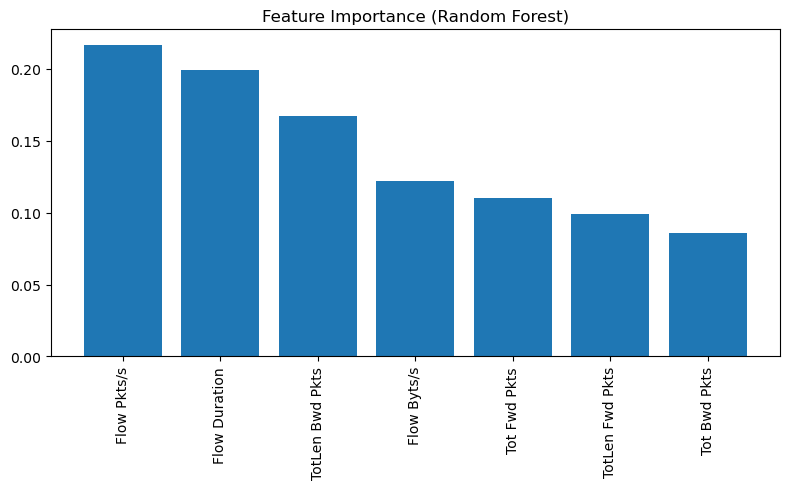

In [25]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

In [26]:
np.__version__

'1.26.4'

In [27]:
import joblib

# 1) fitted scaler on Kaggle training data
joblib.dump(scaler, "scaler.joblib")

# 2) trained random forest
joblib.dump(rf, "rf_model.joblib")

# 3) the exact list and order of feature names
joblib.dump(numeric_cols, "numeric_cols.joblib")

# 4) label encoder, so we can map 0/1 back to original labels
joblib.dump(label_enc, "label_encoder.joblib")


['label_encoder.joblib']

### Hyperparameter tuning

In [48]:
param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [None, 20, 40],
    "min_samples_split": [2, 3, 5, 6],
    "min_samples_leaf": [1, 2],
    "class_weight": ["balanced"]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=444, n_jobs=-1),
    param_grid,
    cv=3,
    scoring="f1_weighted",
    verbose=2
)

grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
print("Best hyperparameters:", grid.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   6.1s
[CV] END class_weight=balanced, max_depth=None, min_samp